In [141]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import (
	LogisticRegression, LogisticRegressionCV
)
from sklearn.metrics import (
	confusion_matrix, classification_report, f1_score,
	roc_curve, roc_auc_score, auc, RocCurveDisplay,
    brier_score_loss
)
from sklearn.model_selection import (
	train_test_split, RandomizedSearchCV, GridSearchCV, 
	cross_val_score, cross_val_predict, KFold, StratifiedKFold,
    RepeatedStratifiedKFold
)
from sklearn.preprocessing import (
	LabelEncoder, OneHotEncoder, StandardScaler,
	RobustScaler, QuantileTransformer, PolynomialFeatures
)
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


SEED = 123
TEST_SIZE = 0.3

In [2]:
with open(Path('../data/df.pkl'), 'rb') as f:
    df = pickle.load(f)

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   pid                   148 non-null    object  
 1   study                 148 non-null    object  
 2   sample_id             148 non-null    object  
 3   class                 148 non-null    category
 4   age_years             148 non-null    float64 
 5   gender                148 non-null    category
 6   smoking_status        148 non-null    category
 7   packyears             148 non-null    float64 
 8   artery_number_5       148 non-null    int64   
 9   artery_volume_5       148 non-null    float64 
 10  artery_tortuosity_5   148 non-null    float64 
 11  artery_number_10      148 non-null    int64   
 12  artery_volume_10      148 non-null    float64 
 13  artery_tortuosity_10  148 non-null    float64 
 14  artery_number_15      148 non-null    int64   
 15  artery

,pid,study,sample_id,class,age_years,gender,smoking_status,packyears,artery_number_5,artery_volume_5,...,artery_tortuosity_15,vein_number_5,vein_volume_5,vein_tortuosity_5,vein_number_10,vein_volume_10,vein_tortuosity_10,vein_number_15,vein_volume_15,vein_tortuosity_15
0,2008-420,Cooper,420-1,Malignant,65.0,M,former,5.0,1,0.005662,...,1.00000,1,0.013388,1.00000,1,0.021113,1.00000,1,0.034588,1.02139
1,03745-2,PLuSS,LS15-0098,Benign,69.4,M,former,41.0,0,0.001250,...,1.02196,0,0.000000,1.00000,1,0.055875,1.00000,3,0.111875,1.00000
2,03533-3,PLuSS,LS15-0162,Benign,66.5,F,former,60.0,1,0.034375,...,1.23261,0,0.000000,1.00000,1,0.032750,1.00000,2,0.091125,1.41931
3,03336-8,PLuSS,LS14-0337,Benign,69.6,M,former,75.0,1,0.014500,...,1.03730,2,0.038750,1.03580,4,0.106625,1.03850,9,0.262000,1.04822
4,03244-8,PLuSS,LS15-0063,Benign,70.4,M,former,37.0,4,0.255750,...,1.17149,5,0.388542,1.13853,10,0.520625,1.10964,15,0.892933,1.08346


In [3]:
demo_cols = ['age_years', 'gender', 'smoking_status', 'packyears']
artery_cols = list(df.filter(regex='artery_', axis=1).columns)
vein_cols =   list(df.filter(regex='vein_',   axis=1).columns)
all_features = demo_cols + artery_cols + vein_cols

X = df.loc[:, all_features]

le = LabelEncoder()
y = le.fit_transform(df.loc[:, 'class'])

for i, label in enumerate(le.classes_):
    print(f"{i} = {label}")

y

0 = Benign
1 = Malignant


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0])

# Train/Test Approach

# CV Approach

In [169]:
# Categorical

ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

X_cat = pd.DataFrame(
    ohe.fit_transform(X.select_dtypes('category')),
    index=X.index,
    columns=ohe.get_feature_names_out()
)

# Numeric
scaler = StandardScaler()

X_num = pd.DataFrame(
    scaler.fit_transform(X.select_dtypes(['int', 'float'])),
    index=X.index,
    columns=X.select_dtypes(['int', 'float']).columns
)

Xp = pd.concat([X_cat, X_num], axis=1)

# poly_feat = PolynomialFeatures(degree=2)
# X_poly = pd.DataFrame(
#     poly_feat.fit_transform(Xp), 
#     index=Xp.index,
#     columns=poly_feat.get_feature_names_out()
# )

print(f"Shape(train): {Xp.shape}")
Xp.head()

Shape(train): (148, 22)


,gender_M,smoking_status_former,age_years,packyears,artery_number_5,artery_volume_5,artery_tortuosity_5,artery_number_10,artery_volume_10,artery_tortuosity_10,...,artery_tortuosity_15,vein_number_5,vein_volume_5,vein_tortuosity_5,vein_number_10,vein_volume_10,vein_tortuosity_10,vein_number_15,vein_volume_15,vein_tortuosity_15
0,1.0,1.0,0.044300,-1.767294,-0.629105,-0.447897,-0.367811,-0.830777,-0.591388,-0.513671,...,-0.644236,-0.670786,-0.607408,-0.434905,-0.797228,-0.782116,-0.483555,-0.911082,-0.899638,-0.343381
1,1.0,1.0,0.854644,-0.254843,-0.890643,-0.457818,-0.367811,-0.830777,-0.589878,-0.513671,...,-0.445152,-0.922757,-0.649967,-0.434905,-0.797228,-0.727145,-0.483555,-0.758720,-0.830100,-0.553693
2,0.0,1.0,0.320554,0.543395,-0.629105,-0.383339,-0.367811,-0.704410,-0.549302,-0.394587,...,1.464552,-0.922757,-0.649967,-0.434905,-0.797228,-0.763714,-0.483555,-0.834901,-0.848770,3.569059
3,1.0,1.0,0.891477,1.173583,-0.629105,-0.428026,-0.367811,-0.325310,-0.516758,-0.106214,...,-0.306083,-0.418816,-0.526783,-0.123685,-0.417025,-0.646891,-0.112928,-0.301635,-0.695027,-0.079583
4,1.0,1.0,1.038813,-0.422893,0.155509,0.114401,1.314266,-0.072576,-0.148856,2.157289,...,0.910452,0.337096,0.585183,0.769377,0.343382,0.007792,0.571914,0.155450,-0.127355,0.266905


In [171]:
demo_cols = ['age_years', 'gender_M', 'smoking_status_former', 'packyears']

artery5_cols = ['artery_number_5', 'artery_volume_5', 'artery_tortuosity_5']
artery10_cols = ['artery_number_10', 'artery_volume_10', 'artery_tortuosity_10']
artery15_cols = ['artery_number_15', 'artery_volume_15', 'artery_tortuosity_15']
artery_cols = artery5_cols + artery10_cols + artery15_cols

vein5_cols = ['vein_number_5', 'vein_volume_5', 'vein_tortuosity_5']
vein10_cols = ['vein_number_10', 'vein_volume_10', 'vein_tortuosity_10']
vein15_cols = ['vein_number_15', 'vein_volume_15', 'vein_tortuosity_15']
vein_cols = vein5_cols + vein10_cols + vein15_cols

vessel5_cols = artery5_cols + vein5_cols
vessel10_cols = artery10_cols + vein10_cols
vessel15_cols = artery15_cols + vein15_cols
vessel_cols = artery_cols + vein_cols

composite5_cols = demo_cols + vessel5_cols
composite10_cols = demo_cols + vessel10_cols
composite15_cols = demo_cols + vessel15_cols
composite_cols = demo_cols + vessel_cols

model_dfns = {
    'Demo':         demo_cols,
    'Artery5':      artery5_cols,
    'Artery10':     artery10_cols,
    'Artery15':     artery15_cols,
    'Artery':       artery_cols,
    'Vein5':        vein5_cols,
    'Vein10':       vein10_cols,
    'Vein15':       vein15_cols,
    'Vein':         vein_cols,
    'Vessel5':      vessel5_cols,
    'Vessel10':     vessel10_cols,
    'Vessel15':     vessel15_cols,
    'Vessel':       vessel_cols,
    'Composite5':   composite5_cols,
    'Composite10':  composite10_cols,
    'Composite15':  composite15_cols,
    'Composite':    composite_cols,
}


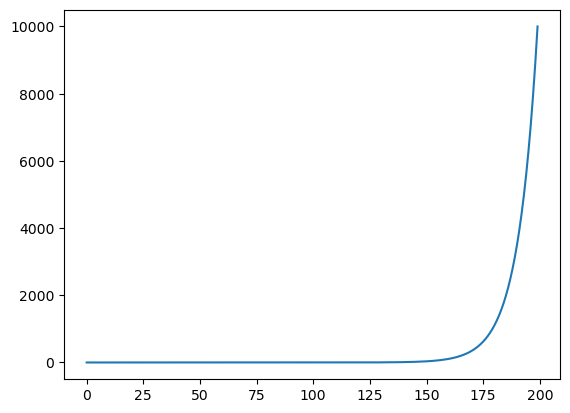

In [172]:
plt.plot(np.logspace(-6, 4, 200, base=10))

In [184]:
cs = np.logspace(-6, 2, 100, base=10)

# DEFINE MODEL
logit_cv = LogisticRegressionCV(
    Cs=cs, 
    fit_intercept=True,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='f1',
    n_jobs=-1,
)

coefficients = pd.DataFrame()

for model_name, model_dfn in tqdm(model_dfns.items()):
    # Fit model
    logit_cv.fit(Xp.loc[:, model_dfn], y)
    temp_coef = pd.DataFrame({model_name: logit_cv.coef_.squeeze()}, index=logit_cv.feature_names_in_)
    coefficients = pd.concat([coefficients, temp_coef], axis=1)

model_dfns_remaining = dict()
for col in coefficients.columns:
    remaining_cols = coefficients.loc[np.abs(coefficients[col]) > 0, col].index
    model_dfns_remaining[col] = remaining_cols

nonzero_coefs = coefficients[np.abs(coefficients) > 0].dropna(how='all')
nonzero_coefs.to_csv('../output/nonzero_coefs_regularized_cv.csv', index=True)
nonzero_coefs

  0%|          | 0/17 [00:00<?, ?it/s]

,Demo,Artery5,Artery10,Artery15,Artery,Vein5,Vein10,Vein15,Vein,Vessel5,Vessel10,Vessel15,Vessel,Composite5,Composite10,Composite15,Composite
age_years,-0.335393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.277030,-0.516459,-0.532709,-0.406839
gender_M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092304,NaN,NaN
smoking_status_former,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.424045,0.296189,0.015736
packyears,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.428566,-0.694646,-0.510887,-0.564402
artery_number_5,NaN,0.312638,NaN,NaN,2.030638,NaN,NaN,NaN,NaN,1.511321,NaN,NaN,1.802234,1.200882,NaN,NaN,2.245608
artery_volume_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.391824,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_tortuosity_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.134160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_number_10,NaN,NaN,0.542005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254897,NaN,NaN,NaN,0.829540,NaN,NaN
artery_volume_10,NaN,NaN,0.291109,NaN,0.033360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.290411,NaN,NaN
artery_tortuosity_10,NaN,NaN,NaN,NaN,-0.035756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.032180,NaN,-0.185152,NaN,-0.382216


In [192]:
model_dfns_remaining_vif = model_dfns_remaining.copy()
for model_name, model_dfn in tqdm(model_dfns_remaining_vif.items()):

    temp_model_dfn = model_dfn.copy()
    print(model_name)
    vif_requirement_met = False
    while not vif_requirement_met:
        vifs = np.array([])
        for i, var_name in enumerate(temp_model_dfn):
            vif = variance_inflation_factor(sm.add_constant(Xp.loc[:, temp_model_dfn]), i)
            vifs = np.append(vifs, vif)

        vifs_series = pd.Series(np.round(vifs, 3), index=temp_model_dfn)
        print(dict(vifs_series))
        
        if np.all(vifs_series < 5):
            print("Requirement met!")
            vif_requirement_met = True
        else:
            vifs_series = vifs_series.drop(vifs_series.idxmax())
            temp_model_dfn = vifs_series.index
            
    model_dfns_remaining_vif[model_name] = temp_model_dfn
        # print(f"VIF (Model: {model_name}, Var: {var_name}): {vif:.3f}")

  0%|          | 0/17 [00:00<?, ?it/s]

Demo
{'age_years': 1.0}
Requirement met!
Artery5
{'artery_number_5': 1.0}
Requirement met!
Artery10
{'artery_number_10': 1.0, 'artery_volume_10': 1.921}
Requirement met!
Artery15
{'artery_volume_15': 1.0}
Requirement met!
Artery
{'artery_number_5': 1.0, 'artery_volume_10': 3.301, 'artery_tortuosity_10': 1.806, 'artery_number_15': 4.297, 'artery_tortuosity_15': 3.094}
Requirement met!
Vein5
{'vein_number_5': 1.0, 'vein_volume_5': 1.646}
Requirement met!
Vein10
{'vein_volume_10': 1.0}
Requirement met!
Vein15
{'vein_volume_15': 1.0}
Requirement met!
Vein
{'vein_number_5': 1.0, 'vein_volume_5': 8.416, 'vein_tortuosity_5': 5.992, 'vein_number_10': 6.155, 'vein_volume_10': 23.706, 'vein_tortuosity_10': 19.35, 'vein_number_15': 8.979, 'vein_volume_15': 15.762, 'vein_tortuosity_15': 14.83}
{'vein_number_5': 1.0, 'vein_volume_5': 8.359, 'vein_tortuosity_5': 4.336, 'vein_number_10': 6.122, 'vein_tortuosity_10': 22.536, 'vein_number_15': 8.975, 'vein_volume_15': 14.505, 'vein_tortuosity_15': 5.89

In [193]:
classifier = LogisticRegression(
    random_state=SEED,
    fit_intercept=True,
    max_iter=1_000, 
    penalty=None, 
    solver='newton-cg',
)

predictions = pd.DataFrame()
regression_results = pd.DataFrame()

for model_name, model_dfn in tqdm(model_dfns_remaining_vif.items()):

    # Predicted probabilities (for ROC curves)
    predicted_probs = cross_val_predict(
        estimator=classifier,
        X=Xp.loc[:, model_dfn],
        y=y,
        cv=5,
        method='predict_proba',
        n_jobs=-1
    )
    predicted_probs = pd.Series(predicted_probs[:, 1], name=model_name)
    predictions = pd.concat([predictions, predicted_probs], axis=1)

    # Regression results (coefs and p-values)
    regression = sm.GLM(y, sm.add_constant(Xp.loc[:, model_dfn]), family=sm.families.Binomial())
    regression = regression.fit()
    temp_regression_results = pd.DataFrame({
        'coefs': regression.params,
        'pvals': regression.pvalues,
        'model': [model_name for _ in range(len(regression.params))]
    })
    regression_results = pd.concat([regression_results, temp_regression_results], axis=0)

ground_truth = pd.Series(y, name='GroundTruth')
predictions = pd.concat([predictions, ground_truth], axis=1)

predictions.to_csv('../output/logit_predictions_cv.csv', index=False)
predictions

  0%|          | 0/17 [00:00<?, ?it/s]

,Demo,Artery5,Artery10,Artery15,Artery,Vein5,Vein10,Vein15,Vein,Vessel5,Vessel10,Vessel15,Vessel,Composite5,Composite10,Composite15,Composite,GroundTruth
0,0.457752,0.264558,0.281762,0.337575,0.357237,0.280173,0.246463,0.232041,0.305467,0.248015,0.227579,0.232041,0.369560,0.586980,0.576220,0.518822,0.785186,1
1,0.356038,0.195117,0.281925,0.360070,0.128174,0.249106,0.260186,0.247514,0.255657,0.187179,0.238233,0.247514,0.119345,0.139016,0.204492,0.195383,0.076231,0
2,0.422219,0.264558,0.303000,0.350989,0.721339,0.249106,0.251002,0.243292,0.255657,0.256693,0.238826,0.243292,0.778780,0.117611,0.130339,0.284801,0.743227,0
3,0.351640,0.264558,0.360141,0.365866,0.134713,0.319956,0.281091,0.279490,0.360283,0.253899,0.288319,0.279490,0.124121,0.059924,0.094974,0.080959,0.022002,0
4,0.334304,0.540320,0.445521,0.450935,0.134752,0.621777,0.481305,0.436875,0.541816,0.604367,0.473186,0.436875,0.141821,0.609573,0.497625,0.465821,0.160933,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,0.596622,0.710127,0.520967,0.471965,0.858437,0.889080,0.839676,0.788871,0.896441,0.791006,0.802303,0.788871,0.753419,0.895956,0.902520,0.838888,0.963080,1
144,0.596622,0.467151,0.399921,0.398883,0.721686,0.606507,0.459569,0.433824,0.646715,0.447960,0.442078,0.433824,0.766000,0.594187,0.455764,0.419641,0.892385,1
145,0.352375,0.238819,0.364375,0.411975,0.103746,0.469145,0.369770,0.352479,0.521672,0.215859,0.353496,0.352479,0.187225,0.015699,0.041927,0.052843,0.005389,0
146,0.547706,0.306477,0.321931,0.368056,0.463354,0.322079,0.303152,0.307070,0.334014,0.329938,0.285453,0.307070,0.471066,0.199504,0.228261,0.206566,0.351290,1


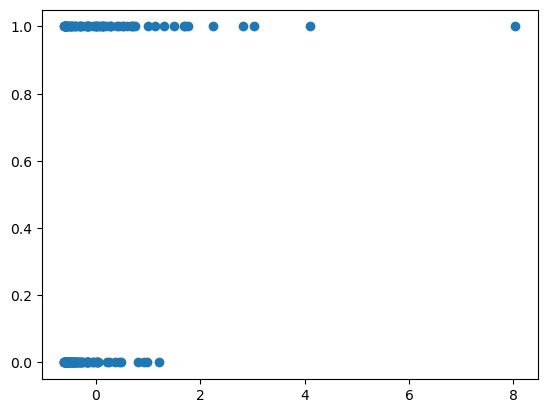

In [179]:
plt.scatter(Xp['artery_volume_10'], y)

In [187]:
regression_results

,coefs,pvals,model
const,-0.115090,5.035913e-01,Demo
age_years,-0.646608,3.093205e-03,Demo
const,-0.015960,9.358530e-01,Artery5
artery_number_5,1.469689,1.711832e-07,Artery5
const,-0.049102,7.948943e-01,Artery10
...,...,...,...
artery_tortuosity_10,-1.159685,4.891521e-02,Composite
artery_number_15,-1.375536,1.449298e-02,Composite
artery_tortuosity_15,1.160601,3.398889e-02,Composite
vein_number_5,0.965639,4.738023e-02,Composite


In [194]:
regression_results_wide = regression_results.pivot(
    columns=['model'],
    values=['coefs', 'pvals']
)
regression_results_wide.columns = regression_results_wide.columns.map(lambda x: '_'.join(x))

regression_results_wide.to_csv('../output/nonzero_coefs_unregularized_cv.csv', index=True)
regression_results_wide

,coefs_Artery,coefs_Artery10,coefs_Artery15,coefs_Artery5,coefs_Composite,coefs_Composite10,coefs_Composite15,coefs_Composite5,coefs_Demo,coefs_Vein,...,pvals_Composite5,pvals_Demo,pvals_Vein,pvals_Vein10,pvals_Vein15,pvals_Vein5,pvals_Vessel,pvals_Vessel10,pvals_Vessel15,pvals_Vessel5
age_years,NaN,NaN,NaN,NaN,-0.660595,-0.519712,-0.598386,-0.468473,-0.646608,NaN,...,0.074826,0.003093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_number_10,NaN,0.538253,NaN,NaN,NaN,0.841797,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130937,NaN,NaN
artery_number_15,-2.052213,NaN,NaN,NaN,-1.375536,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.020008e-03,NaN,NaN,NaN
artery_number_5,3.305963,NaN,NaN,1.469689,3.721088,NaN,NaN,1.594169,NaN,NaN,...,0.000043,NaN,NaN,NaN,NaN,NaN,8.080636e-07,NaN,NaN,0.000916
artery_tortuosity_10,-0.890342,NaN,NaN,NaN,-1.159685,-0.191445,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.176311e-02,NaN,NaN,NaN
artery_tortuosity_15,0.901466,NaN,NaN,NaN,1.160601,NaN,0.249185,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.737732e-02,NaN,NaN,NaN
artery_tortuosity_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.542134
artery_volume_10,0.376664,0.674616,NaN,NaN,NaN,0.293268,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_volume_15,NaN,NaN,0.905211,NaN,NaN,NaN,0.422811,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
artery_volume_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.301169
